# Project description

Film Junky Union, sebuah komunitas baru bagi penggemar film klasik sedang mengembangkan sistem untuk memfilter dan mengategorikan ulasan film. Misi utama dari project ini adalah melatih model agar bisa mendeteksi ulasan negatif secara otomatis. Menggunakan *dataset* ulasan film IMBD dengan pelabelan polaritas untuk membuat sebuah model yang bisa mengklasifikasikan ulasan positif dan negatif. Model ini setidaknya harus memiliki skor F1 sebesar 0,85.

**Tujuan Proyek**
Melatih model agar dapat mendeteksi ulasan negatif atau positif secara otomatis, dan setidaknya memiliki skor F1 sebesar 0.85.

**Instruksi Proyek**
- Memuat data di file `imdb_reviews.tsv.`
- Melakukan pra-pemrosesan data.
- Melakukan EDA dan buat kesimpulan terkait ketidakseimbangan kelas.
- Melakukan pra-pemrosesan data untuk membuat model.
- Melatih setidaknya tiga model untuk train dataset yang ada.
- Menguji model untuk test dataset yang ada.
- Menulis beberapa ulasan Anda sendiri dan klasifikasikan dengan semua model.
- Memeriksa perbedaan antara hasil pengujian model dari dua poin di atas. Cobalah untuk menjelaskan hasilnya.
- Menampilkan hasil temuan.

**Deskripsi Data**
- *Data ini diperoleh dari Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, dan Christopher Potts. (2011). **Learning Word Vectors for Sentiment Analysis.** The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).*

Berikut adalah deskripsi untuk kolom yang dipilih:
- `review`: teks ulasan
- `pos`: target, '0' untuk negatif dan '1' untuk positif
- `ds_part`: 'train'/'test' untuk bagian train/test dari dataset, dan beberapa kolom-kolom lain di dataset.

## Inisialisasi

In [1]:
!pip install transformers

In [2]:
import math

import numpy as np
import pandas as pd
import re
import spacy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import tensorflow as tf
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
import sklearn.metrics as metrics
import torch

import transformers
from transformers import AutoModel, AutoTokenizer, BertTokenizer

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# baris berikutnya menyediakan grafik dengan kualitas yang lebih baik di layar HiDPI 

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# ini untuk menggunakan progress_apply, baca lebih lanjut di https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Memuat data

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [7]:
# membuat fungsi pengolahan data

def display_information(df):
    print('Head:')
    display(df.head())
    print ('-'*100)
    print('Tail:')
    display(df.tail())
    print ('-'*100)
    print('Info:')
    print()
    display(df.info())
    print ('-'*100)
    print('Describe:')
    display(df.describe())
    print ('-'*100)
    print('Skew Factor:')
    display(df.skew())
    print ('-'*100)
    print('Columns with nulls:')
    display(get_precent_of_na_df(df,4))
    print ('-'*100)
    print('Shape:')
    print(df.shape)
    print ('-'*100)
    print('Duplicated:')
    print('Duplicate rows:',df.duplicated().sum(),', Duplicate percentage:', (df.duplicated().sum()*100) / df.shape[0],'%')
    
def get_precent_of_na_df(df,num):
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    return df_nulls

models = []
required_f1 = 0.85
print_separator = '*' * 100

In [8]:
display_information(df_reviews)
print ('-'*100)

Head:


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


----------------------------------------------------------------------------------------------------
Tail:


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164
47330,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,I'll make this brief. This was a joy to watch....,10,pos,1,test,4165


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 

None

----------------------------------------------------------------------------------------------------
Describe:


,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


----------------------------------------------------------------------------------------------------
Skew Factor:


start_year        -1.566152
is_adult          23.963419
average_rating    -0.662190
votes              7.813169
rating            -0.002901
pos                0.004183
idx               -0.010661
dtype: float64

----------------------------------------------------------------------------------------------------
Columns with nulls:


,Missing Values,Percent of Nulls
tconst,0,0.0
title_type,0,0.0
primary_title,0,0.0
original_title,0,0.0
start_year,0,0.0
end_year,0,0.0
runtime_minutes,0,0.0
is_adult,0,0.0
genres,0,0.0
average_rating,2,0.0


----------------------------------------------------------------------------------------------------
Shape:
(47331, 17)
----------------------------------------------------------------------------------------------------
Duplicated:
Duplicate rows: 0 , Duplicate percentage: 0.0 %
----------------------------------------------------------------------------------------------------


## Exploratory Data Analysis

Periksa jumlah film dan ulasan selama beberapa tahun.

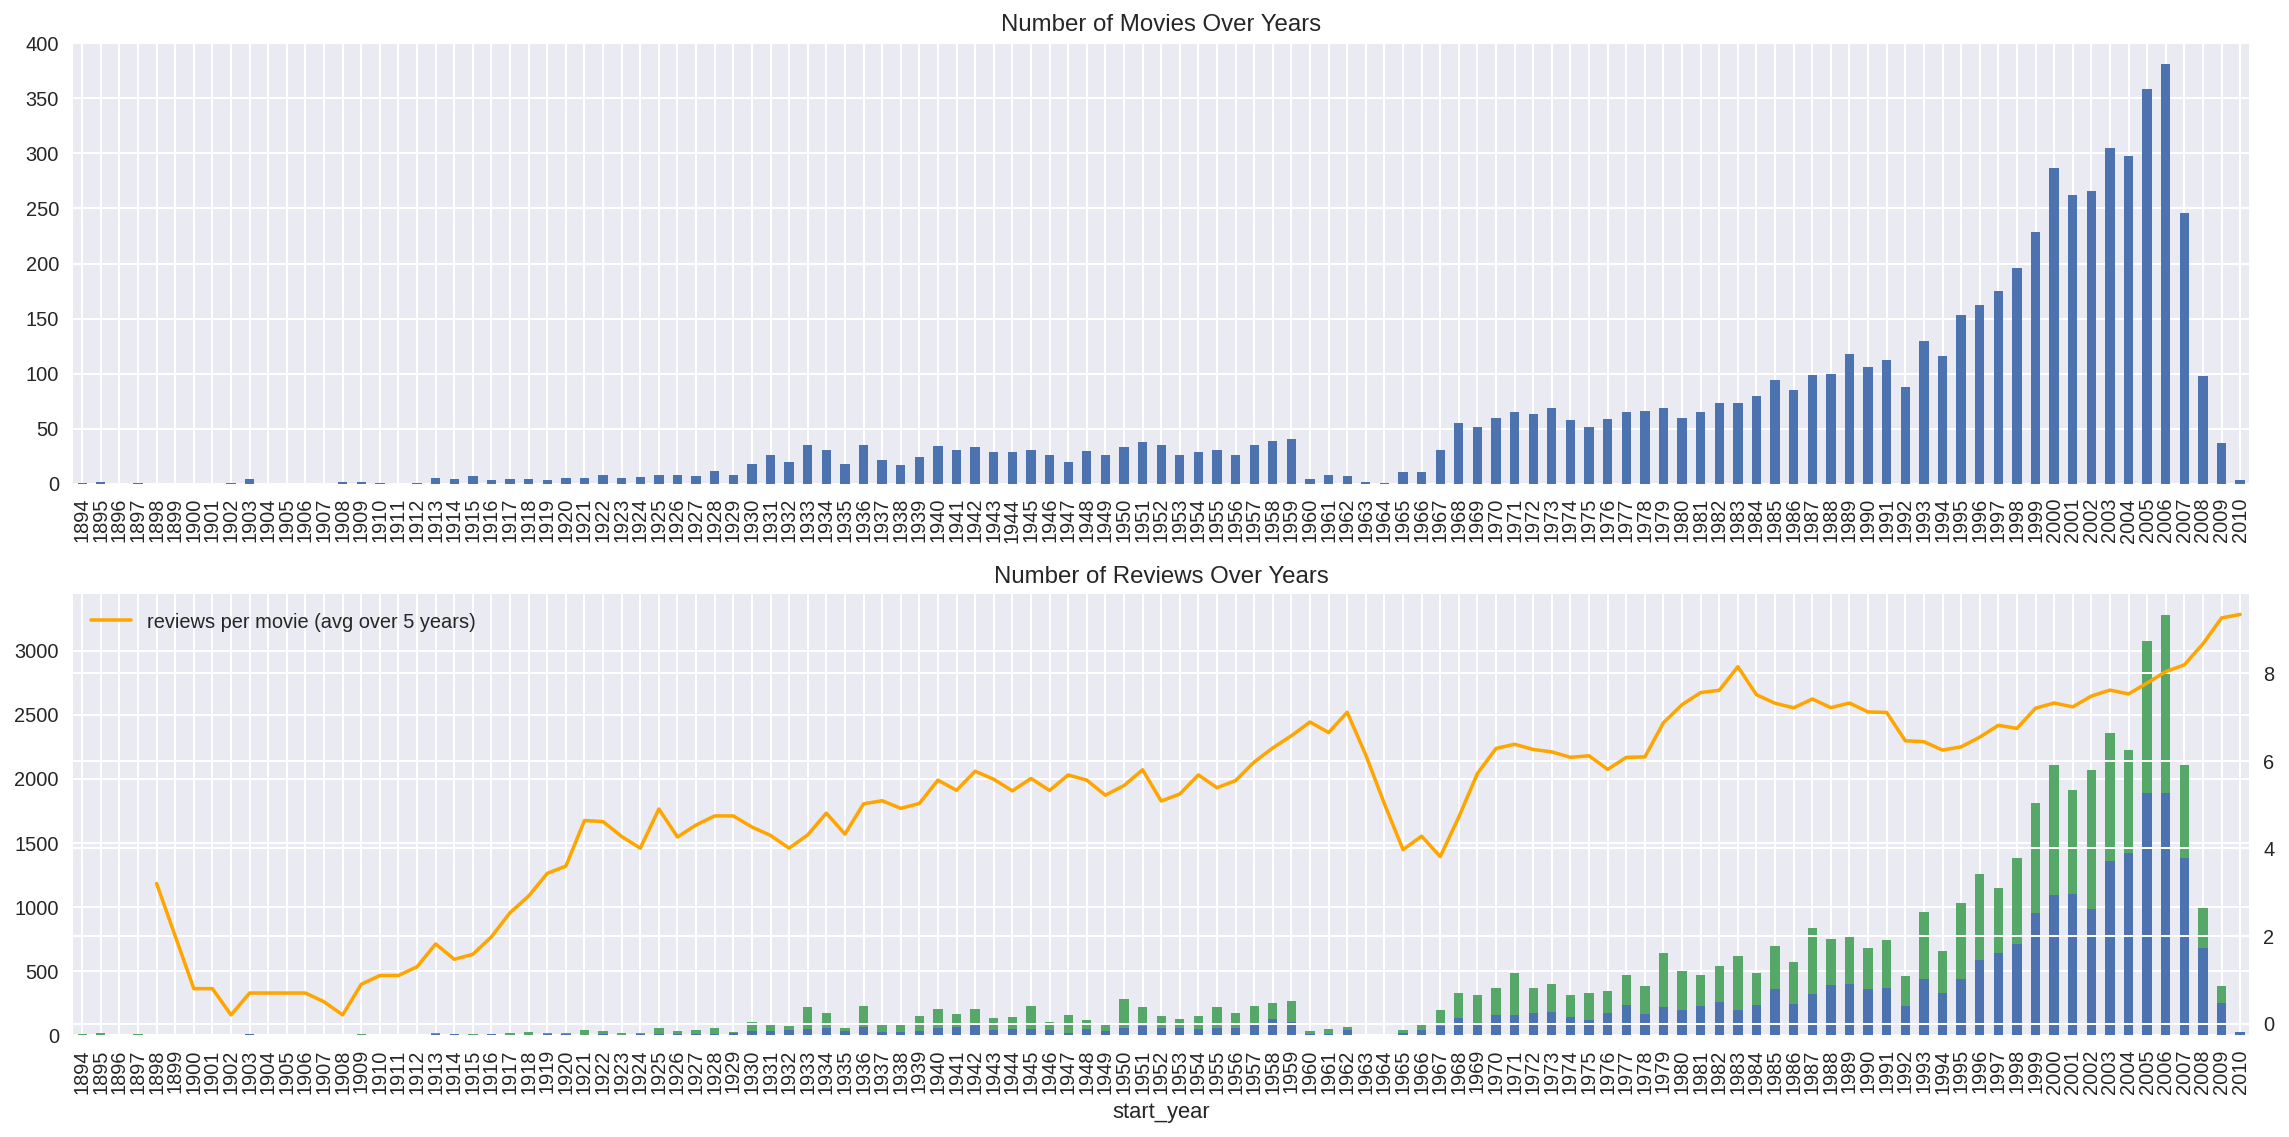

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), (dft1.index.max()+1))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), (dft2.index.max()+1))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), (dft2.index.max()+1))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Periksa distribusi jumlah ulasan per film dengan penghitungan yang tepat dan KDE (hanya untuk mengetahui perbedaannya dari penghitungan yang tepat)

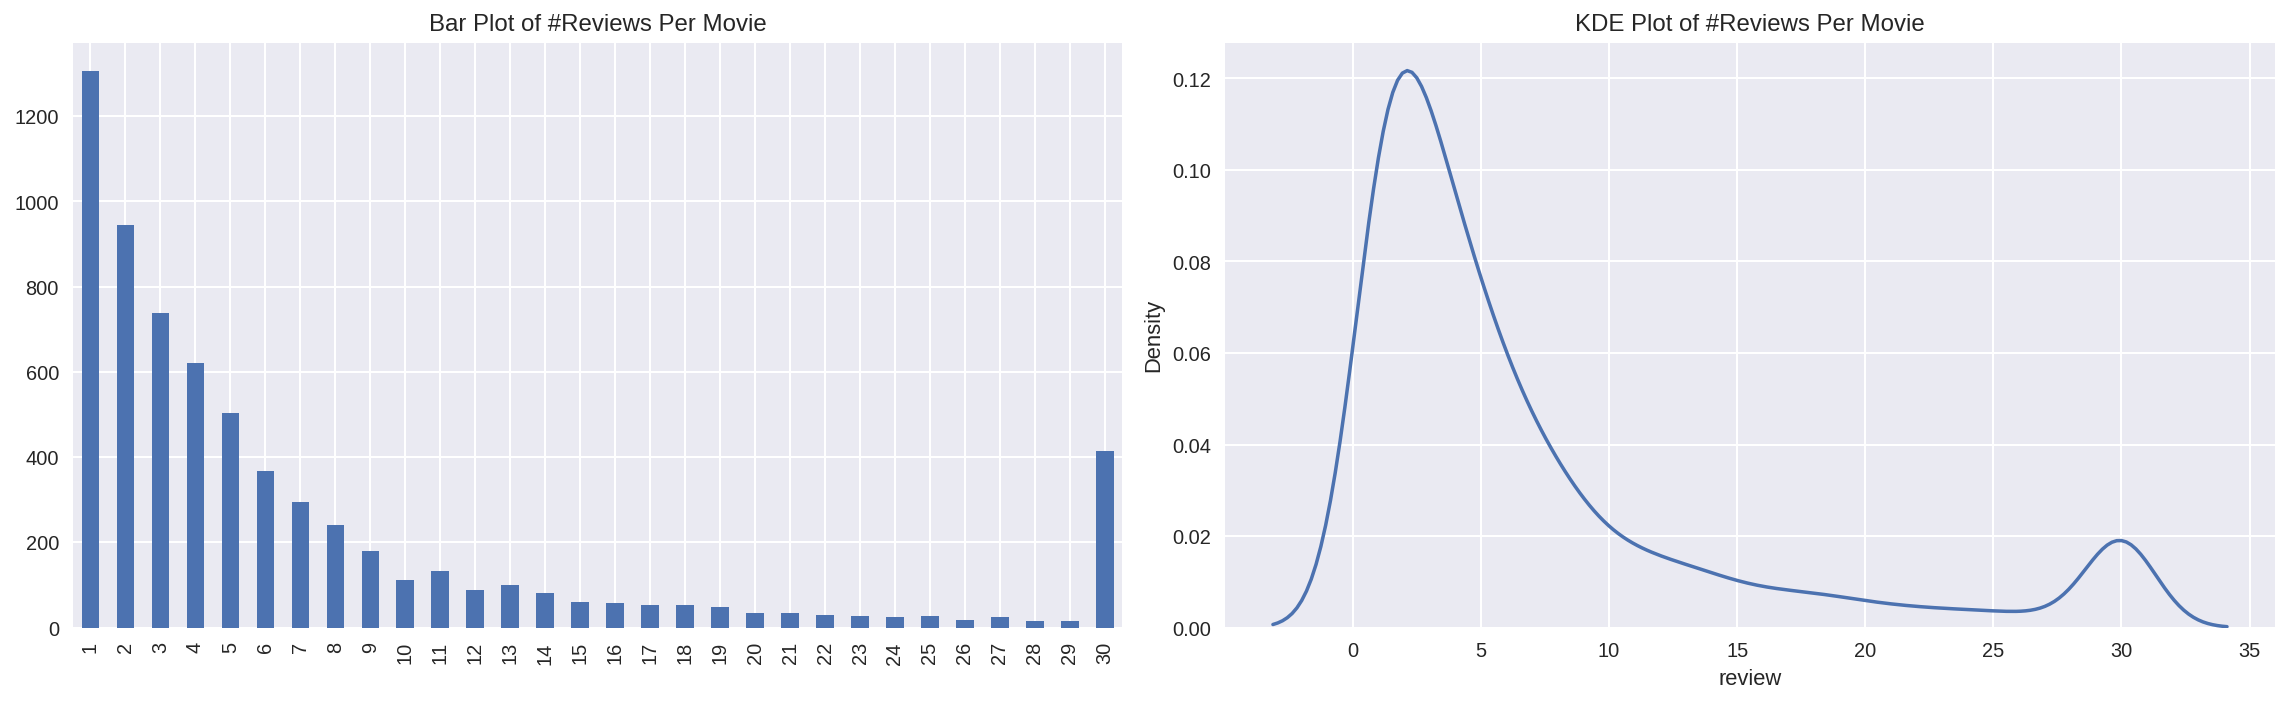

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

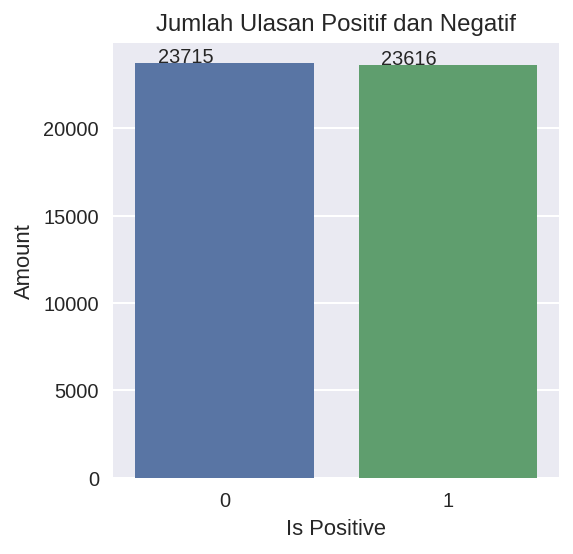

In [12]:
# membuat plot

plt.figure(figsize=(4,4))
splot = sns.countplot(x='pos', data=df_reviews, order=df_reviews['pos'].value_counts().index)
plt.xlabel('Is Positive')
plt.ylabel('Amount')
plt.title('Jumlah Ulasan Positif dan Negatif')
for p in splot.patches:
        splot.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

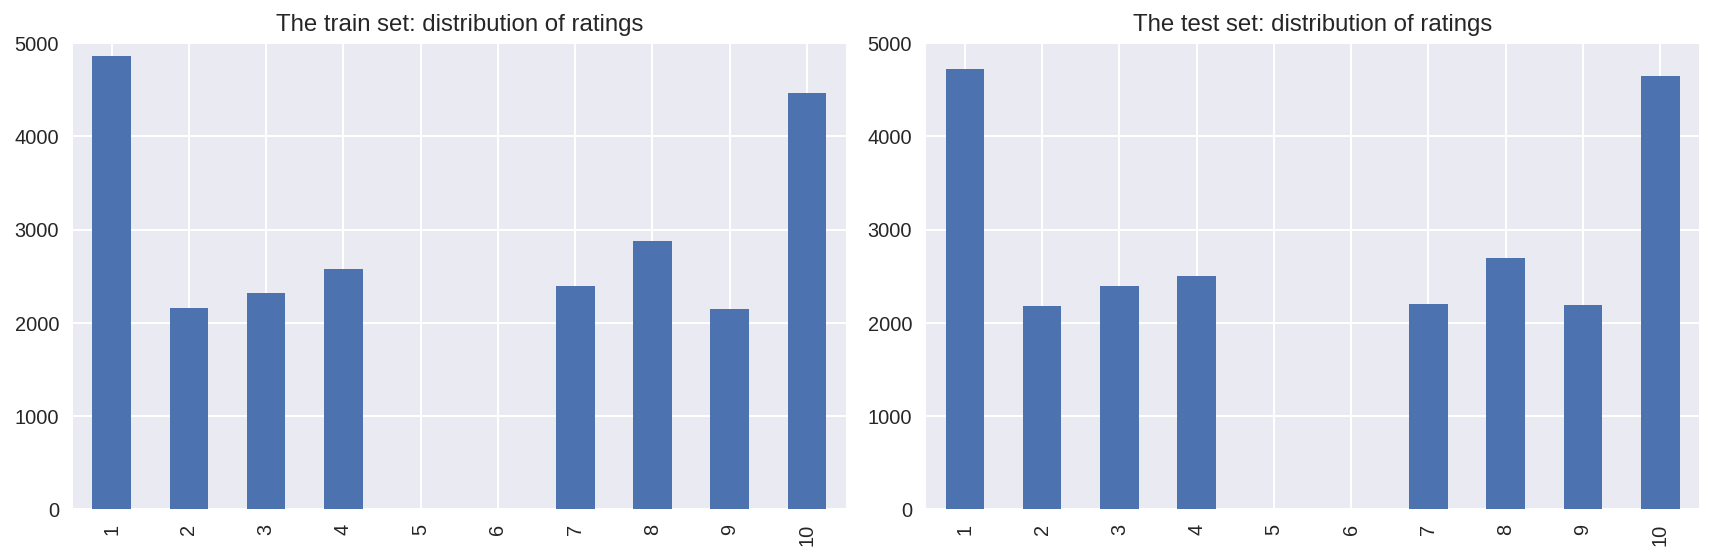

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribusi ulasan negatif dan positif selama bertahun-tahun untuk dua bagian *dataset*

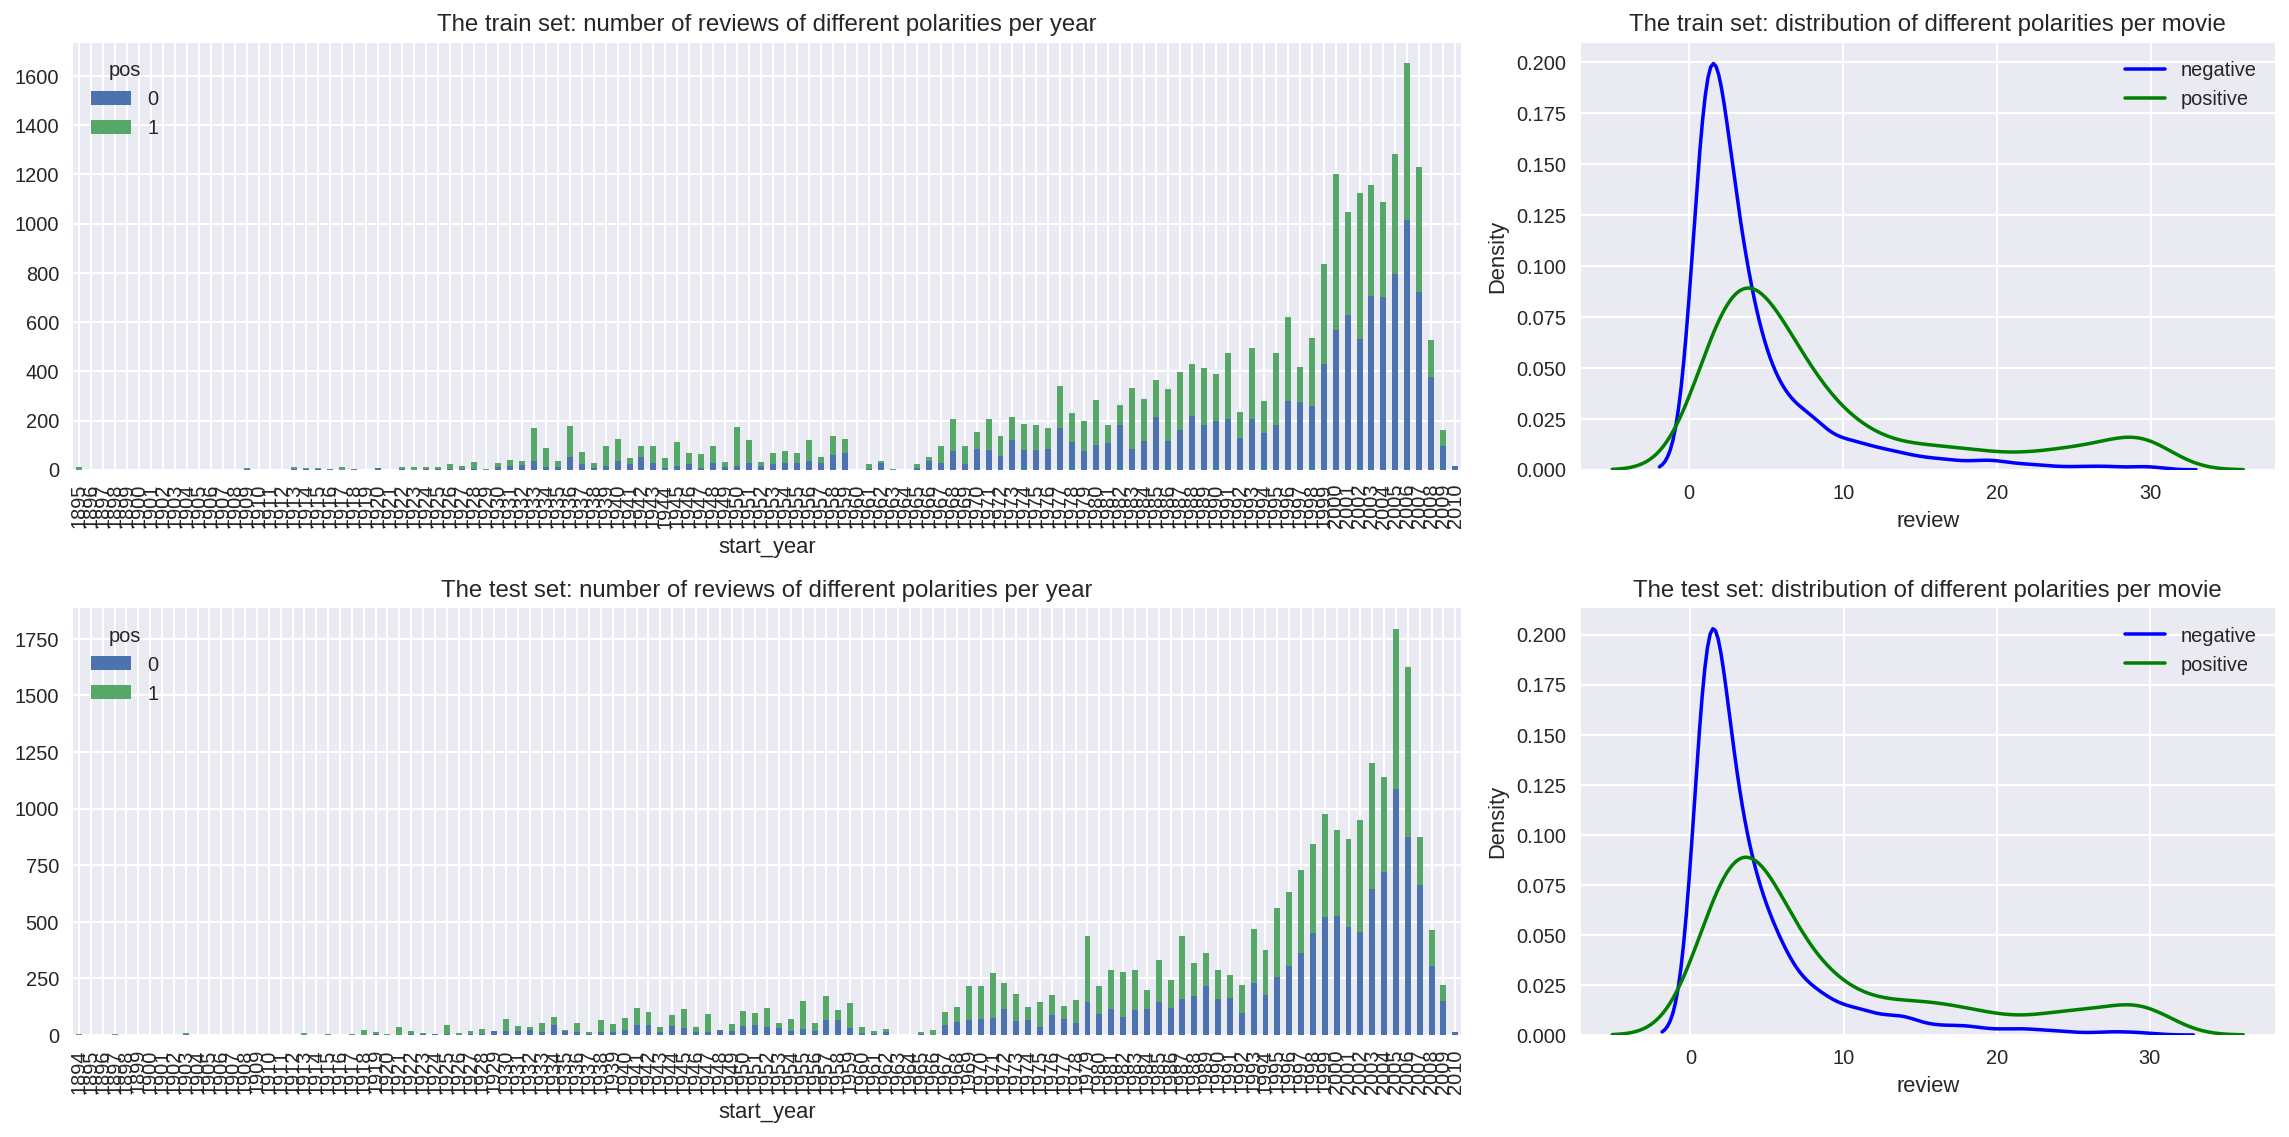

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), (dft.index.max()+1))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.set_xlabel('review')
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), (dft.index.max()+1))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.set_xlabel('review')
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

**Kesimpulan:**
- Meski jumlah review positif dan negatifnya sama, namun distribusi review positif dan negatifnya sedikit berbeda.

## Prosedur Evaluasi

Menyusun evaluasi yang dapat digunakan untuk semua model dalam tugas ini secara rutin

In [15]:
df_results = pd.DataFrame()

def evaluate_model(model, model_name, train_features, train_target, test_features, test_target):
    global df_results

    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    df_eval_stats.columns = model_name +' '+ df_eval_stats.columns
    df_results = pd.concat([df_results,df_eval_stats],axis=1)

## Normalisasi

Kita menganggap semua model di bawah menerima teks dalam huruf kecil dan tanpa angka, tanda baca, dll.

In [16]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')
df_reviews[['review','review_norm']].head()

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenti...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in...
4,I'm totally agree with GarryJohal from Singapo...,i m totally agree with garryjohal from singapo...


## Pemisahan Train / Test

Untungnya, seluruh *dataset* sudah dibagi menjadi *train/test*. Bendera yang sesuai adalah 'ds_part'.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [18]:
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']
print(train_features.shape,test_features.shape)
print(train_target.shape,test_target.shape)

(23796,) (23535,)
(23796,) (23535,)


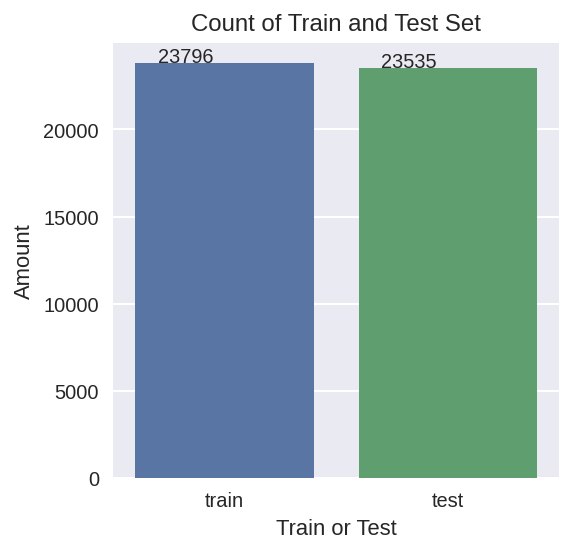

In [19]:
# membuat plot

plt.figure(figsize=(4,4))
splot = sns.countplot(x='ds_part', data=df_reviews, order=df_reviews['ds_part'].value_counts().index)
plt.xlabel('Train or Test')
plt.ylabel('Amount')
plt.title('Count of Train and Test Set')
for p in splot.patches:
        splot.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

## Bekerja dengan Model

### Model 0 - Konstan

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


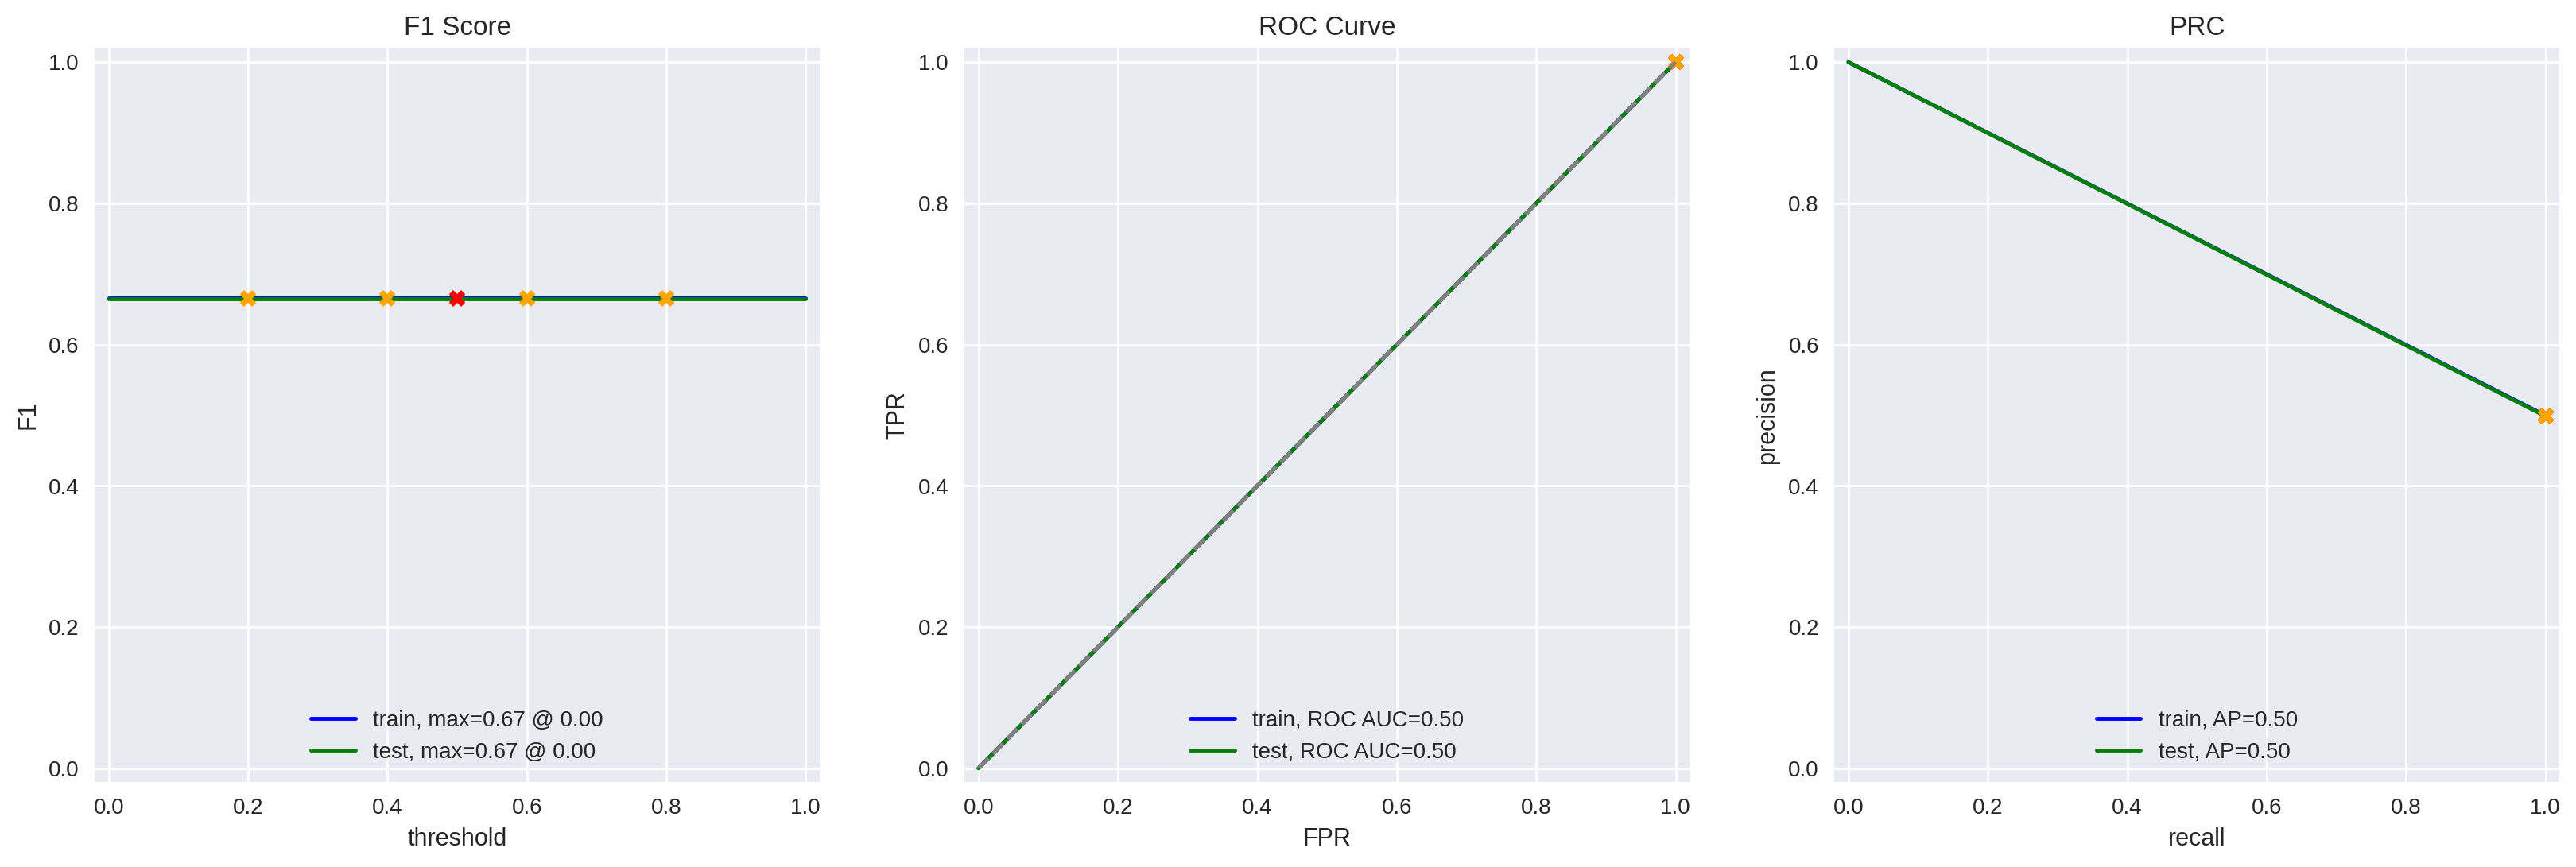

In [41]:
dummy_clf = DummyClassifier(strategy='constant', constant=1)
model_0 = dummy_clf.fit(train_features,train_target)
evaluate_model(model_0, 'Mod-0', train_features, train_target, test_features, test_target)
models.append(['DummyClassifier'])

### Model 1 - NLTK, TF-IDF dan LR

TF-IDF

In [42]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)

In [43]:
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

print("The TF-IDF train matrix size", train_features_1.shape)
print("The TF-IDF test matrix size", test_features_1.shape)

The TF-IDF train matrix size (23796, 71531)
The TF-IDF test matrix size (23535, 71531)


In [44]:
model_1 = LogisticRegression(random_state=12345)
model_1.fit(train_features_1,train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


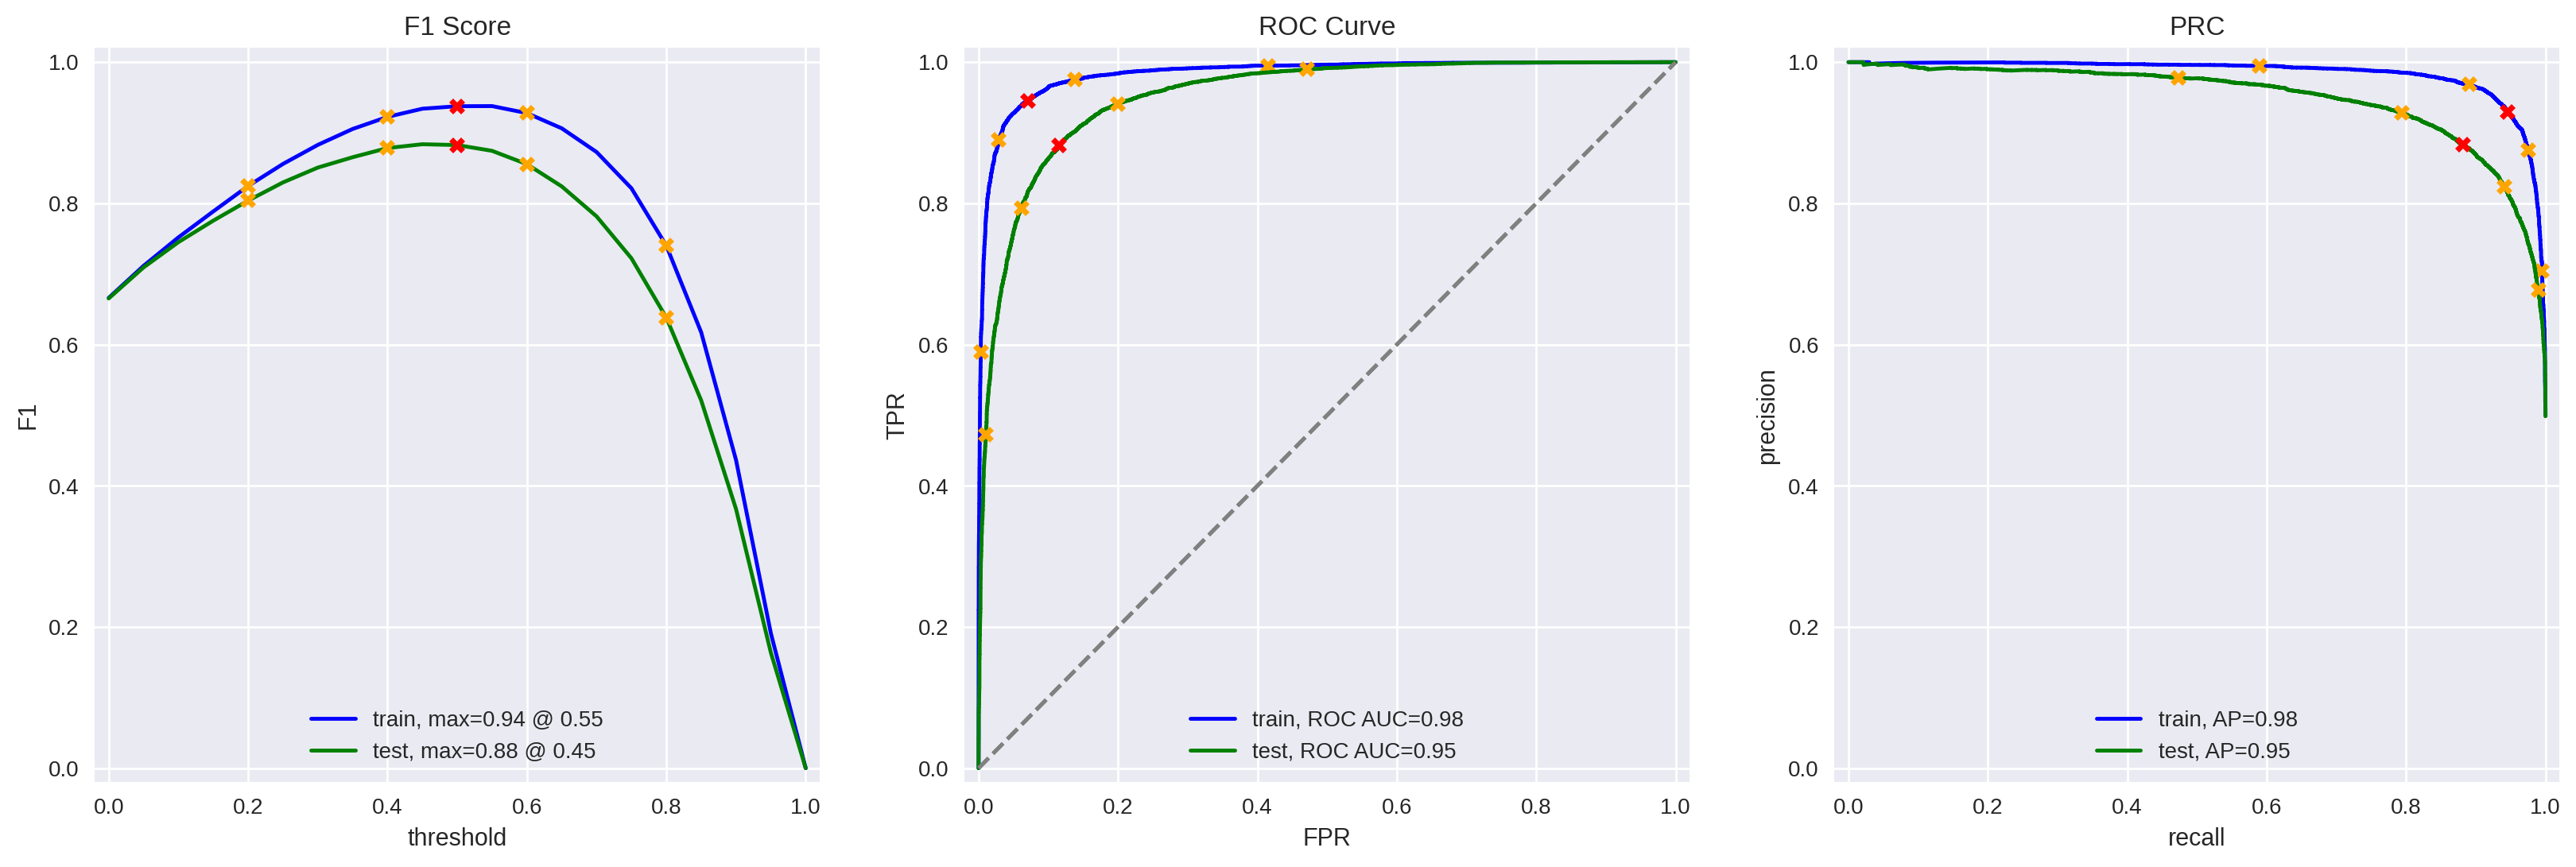

In [45]:
evaluate_model(model_1,'Mod-1', train_features_1, train_target, test_features_1, test_target)
models.append(['NLTK TF-IDF LR'])

**Kesimpulan:**
- Model regresi logistik dengan NLTK, TF-IDF menghasilkan nilai F1 yang jauh lebih baik dibandingkan model dummy classifier dan melewati nilai threshold.
- Untuk sementara metode vektorisasi ini dapat kami jadikan model terbaik walaupun ada sedikit perbedaan antara train dan test.

### Model 2 - spaCy, TF-IDF dan LR

In [46]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [47]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [48]:
%%time

review_spacy = []
corpus_norm = df_reviews['review_norm']
for textnorm in corpus_norm:
    review_spacy.append(text_preprocessing_3(textnorm))

df_reviews['review_spacy'] =  review_spacy

print(df_reviews[['review_norm','review_spacy']].head())
print()

                                         review_norm  \
0  the pakage implies that warren beatty and gold...   
1  how the hell did they get this made   presenti...   
2  there is no real story the film seems more lik...   
3  um      a serious film about troubled teens in...   
4  i m totally agree with garryjohal from singapo...   

                                        review_spacy  
0  the pakage imply that warren beatty and goldie...  
1  how the hell do they get this make    present ...  
2  there be no real story the film seem more like...  
3  um       a serious film about troubled teen in...  
4  I m totally agree with garryjohal from singapo...  

CPU times: user 14min 20s, sys: 2.14 s, total: 14min 22s
Wall time: 14min 39s


In [49]:
df_spacy_train = df_reviews.query('ds_part == "train"').copy()
df_spacy_test = df_reviews.query('ds_part == "test"').copy()

print(df_spacy_train.shape)
print(df_spacy_test.shape)

(23796, 19)
(23535, 19)


In [50]:
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)

In [51]:
train_features_2 = tfidf_vectorizer_2.fit_transform(df_spacy_train['review_spacy'])
test_features_2 = tfidf_vectorizer_2.transform(df_spacy_test['review_spacy'])

print("The TF-IDF train matrix size", train_features_2.shape)
print("The TF-IDF test matrix size", test_features_2.shape)

The TF-IDF train matrix size (23796, 58813)
The TF-IDF test matrix size (23535, 58813)


In [52]:
model_2 = LogisticRegression(random_state=12345)
model_2.fit(train_features_2,train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


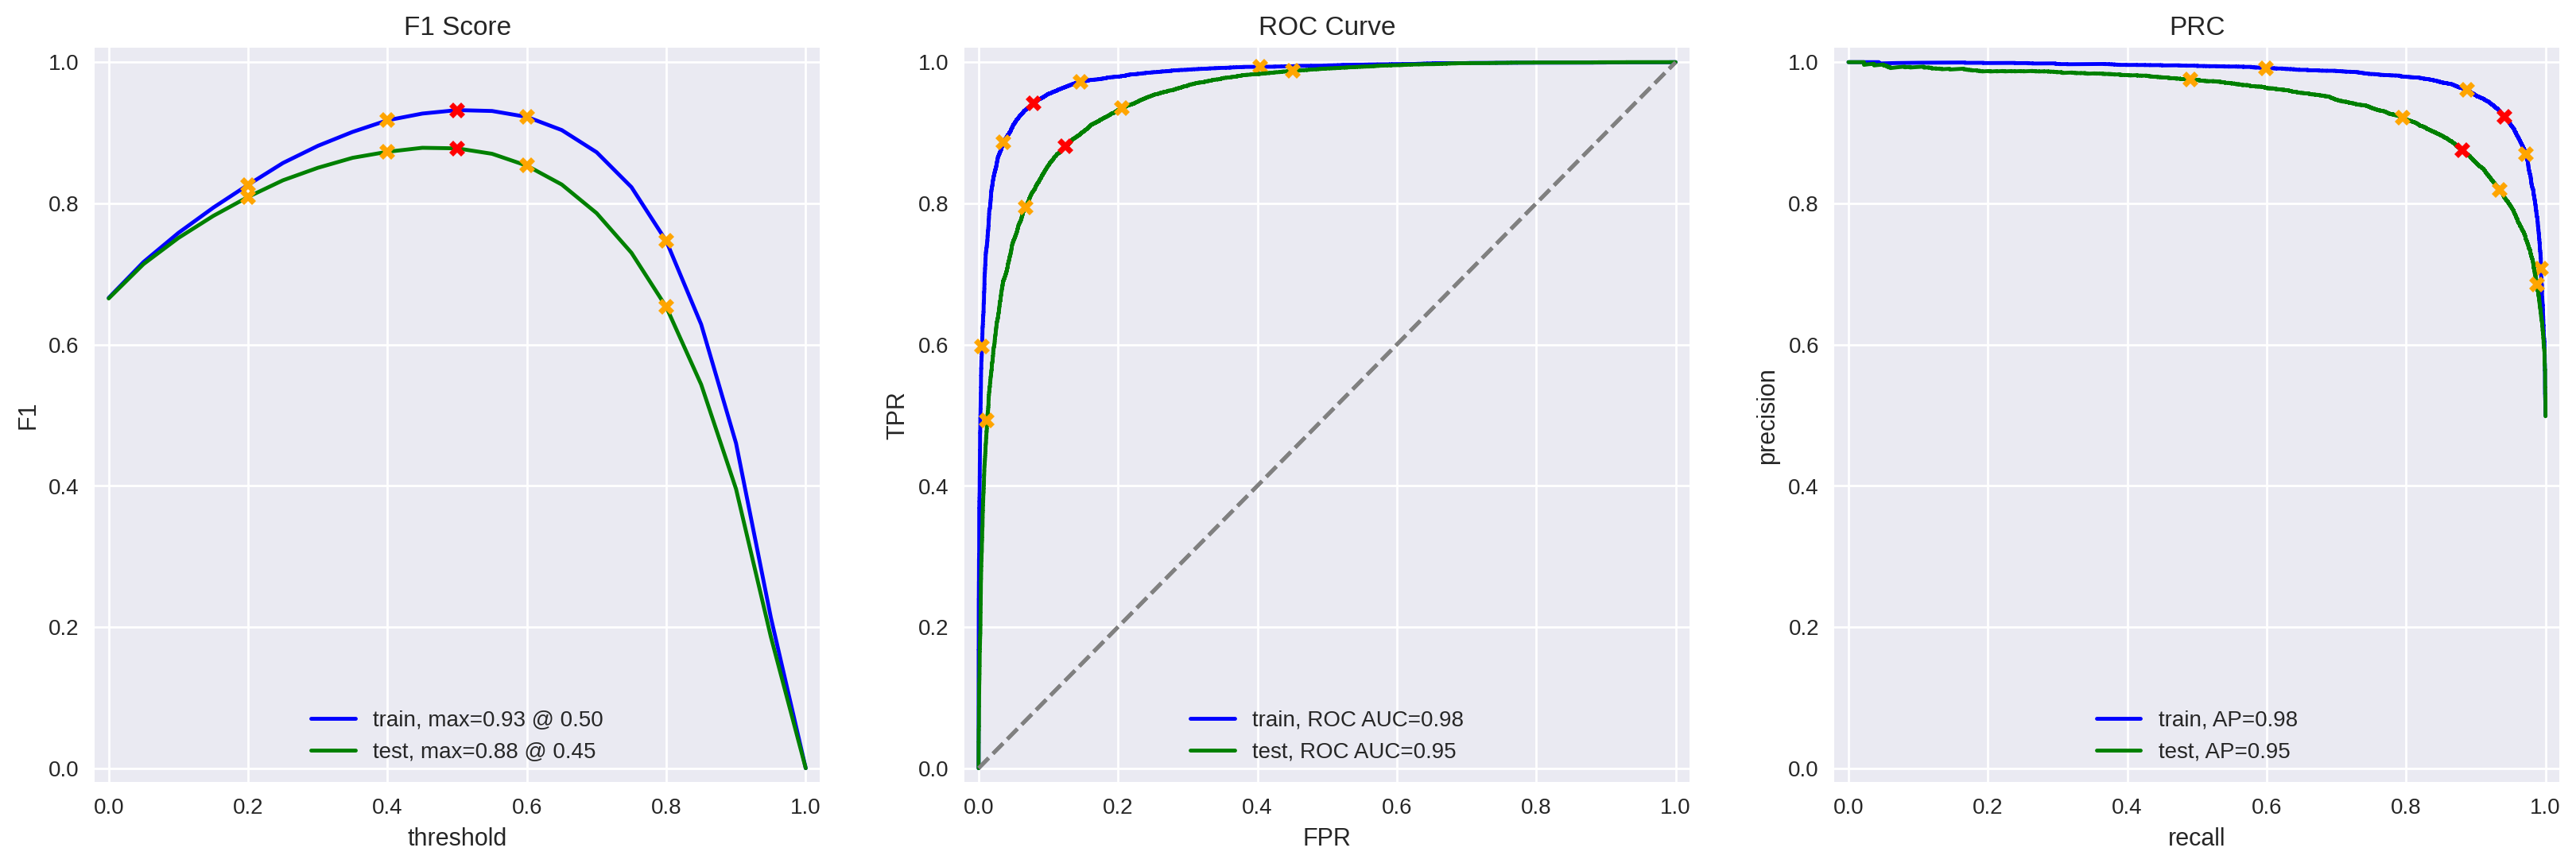

In [53]:
evaluate_model(model_2, 'Mod-2', train_features_2, train_target, test_features_2, test_target)
models.append(['spaCy TF-IDF LR'])

### Model 3 - spaCy, TF-IDF dan LGBMClassifier

In [54]:
model_3 = LGBMClassifier(random_state=12345)
model_3.fit(train_features_2, train_target)

LGBMClassifier(random_state=12345)

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


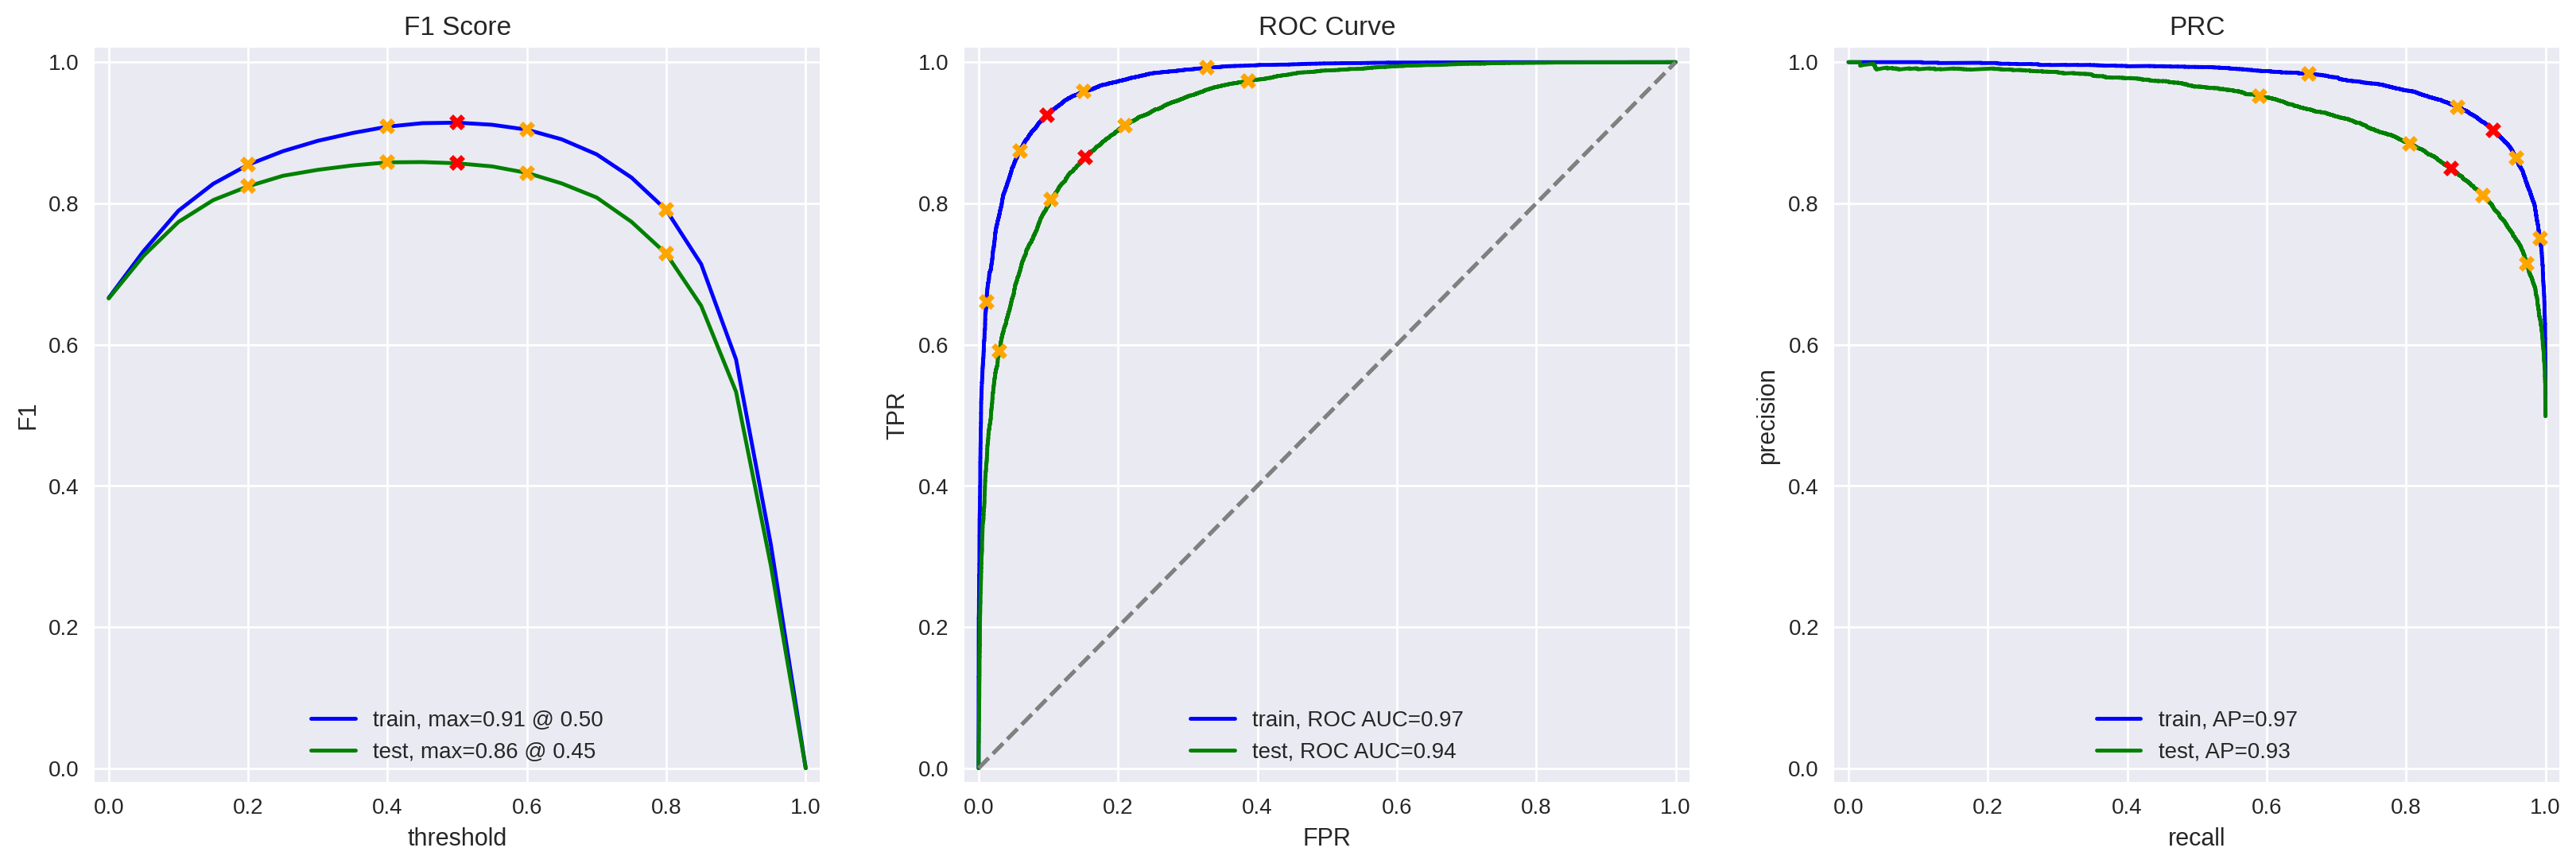

In [55]:
evaluate_model(model_3, 'Mod-3', train_features_2, train_target, test_features_2, test_target)
models.append(['spaCy TF-IDF LGBM'])

### Model 4 - spaCy, TF-IDF dan XGBoostClassifier

In [56]:
model_4 = XGBClassifier(random_state=12345)
model_4.fit(train_features_2, train_target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=12345, ...)

          train  test
Accuracy   0.95  0.85
F1         0.95  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


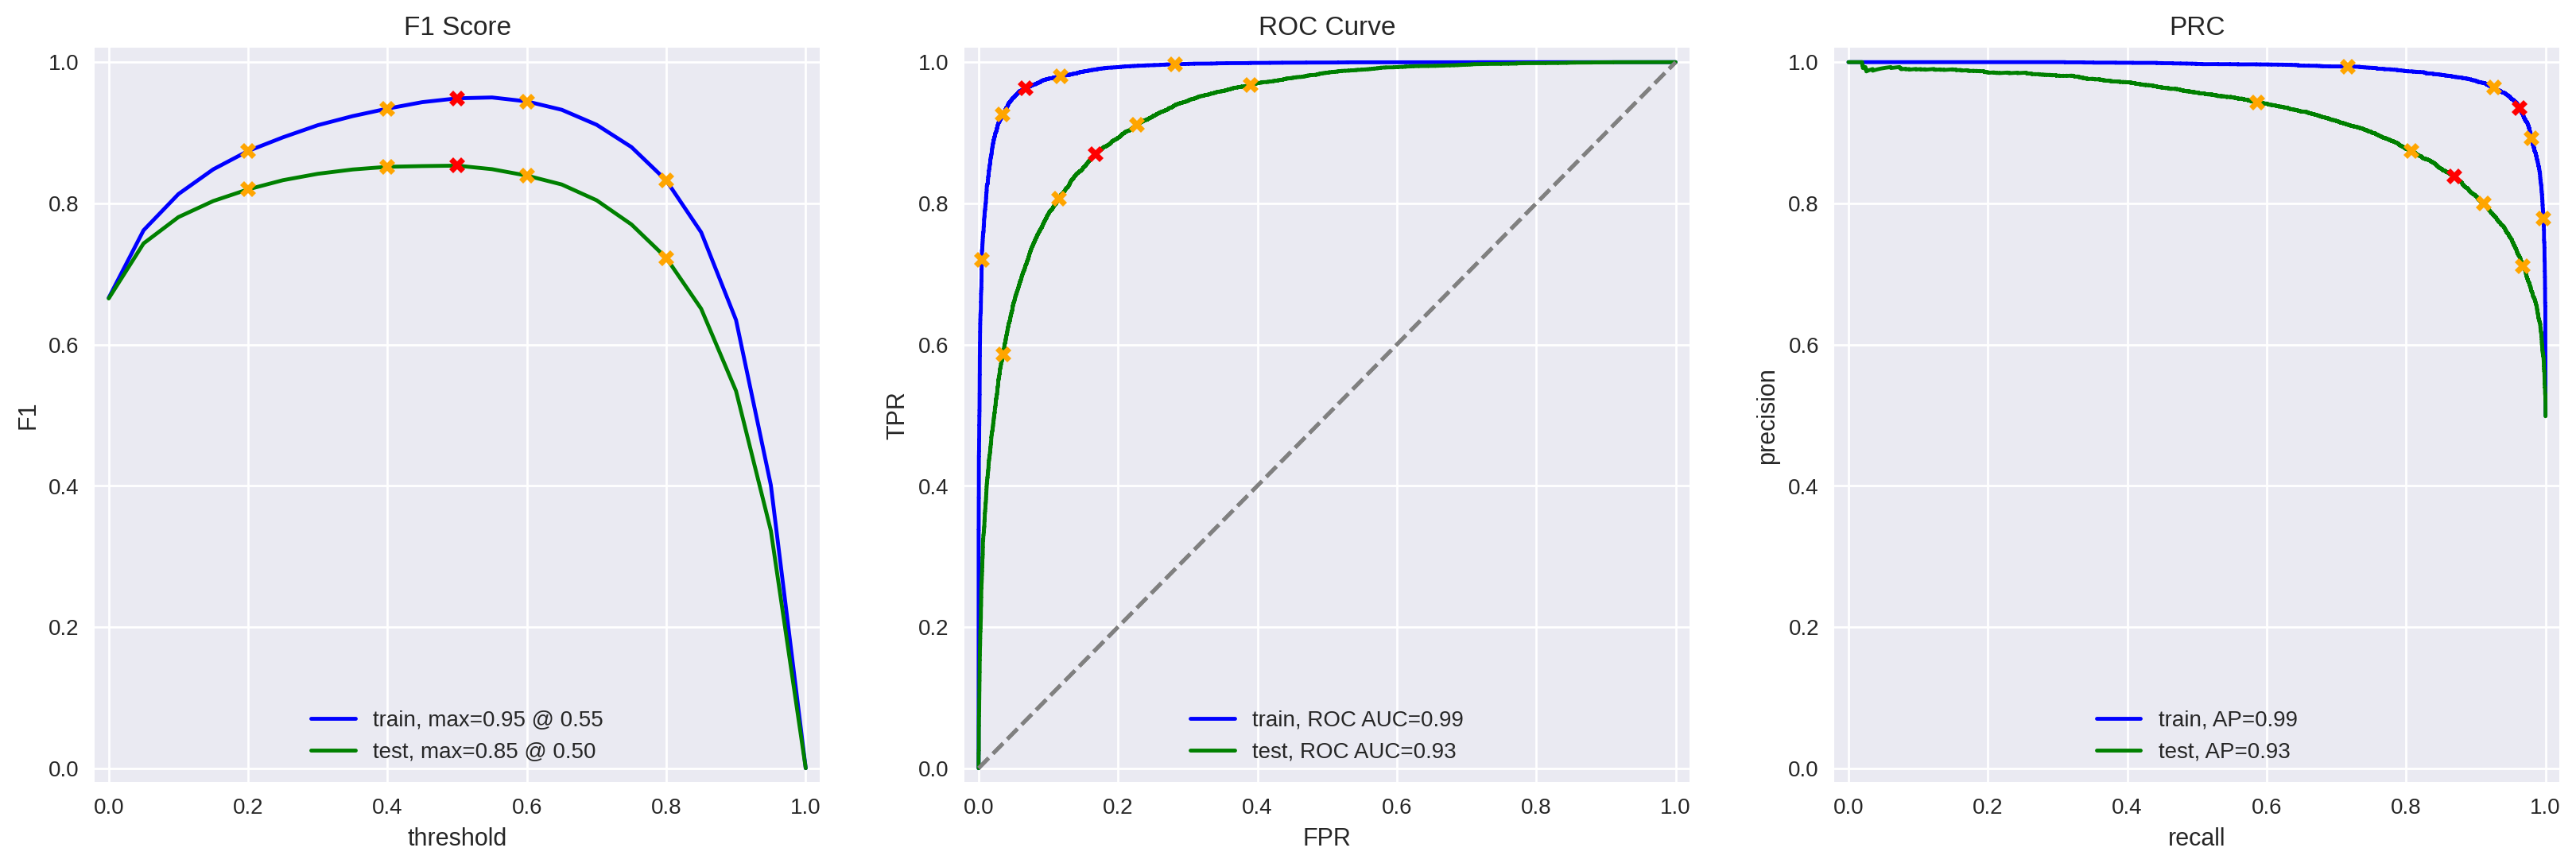

In [57]:
evaluate_model(model_4, 'Mod-4', train_features_2, train_target, test_features_2, test_target)
models.append(['spaCy TF-IDF XGB'])

###  Model 5 - BERT

In [58]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [59]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    
    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        
        # teks ke id token yang sudah di-padded bersamaan dengan attention mask
        padded = np.array(ids + [0]*(max_length - len(ids)))
        
        # <masukkan kode di sini untuk ids_list dan attention_mask_list>
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
        
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Gunakan {device} perangkat.')
    
    # dapatkan embedding dalam batch 

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <masukkan kode di sini untuk membuat attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [60]:
# Perhatian! Menjalankan BERT untuk ribuan teks mungkin memakan waktu lama di CPU, setidaknya beberapa jam
%%time

train_features_5 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

Gunakan cuda perangkat.


  0%|          | 0/238 [00:00<?, ?it/s]

CPU times: user 13min 50s, sys: 1.8 s, total: 13min 52s
Wall time: 14min 5s


In [61]:
%%time

test_features_5 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

Gunakan cuda perangkat.


  0%|          | 0/236 [00:00<?, ?it/s]

CPU times: user 13min 50s, sys: 1.24 s, total: 13min 51s
Wall time: 13min 54s


In [62]:
print(df_reviews_train['review_norm'].shape)
print(train_features_5.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796,)


In [63]:
print(df_reviews_test['review_norm'].shape)
print(test_features_5.shape)
print(test_target.shape)

(23535,)
(23535, 768)
(23535,)


In [64]:
model_5 = LogisticRegression()
model_5.fit(train_features_5, train_target)

LogisticRegression()

          train  test
Accuracy   0.87  0.86
F1         0.87  0.86
APS        0.94  0.94
ROC AUC    0.94  0.94


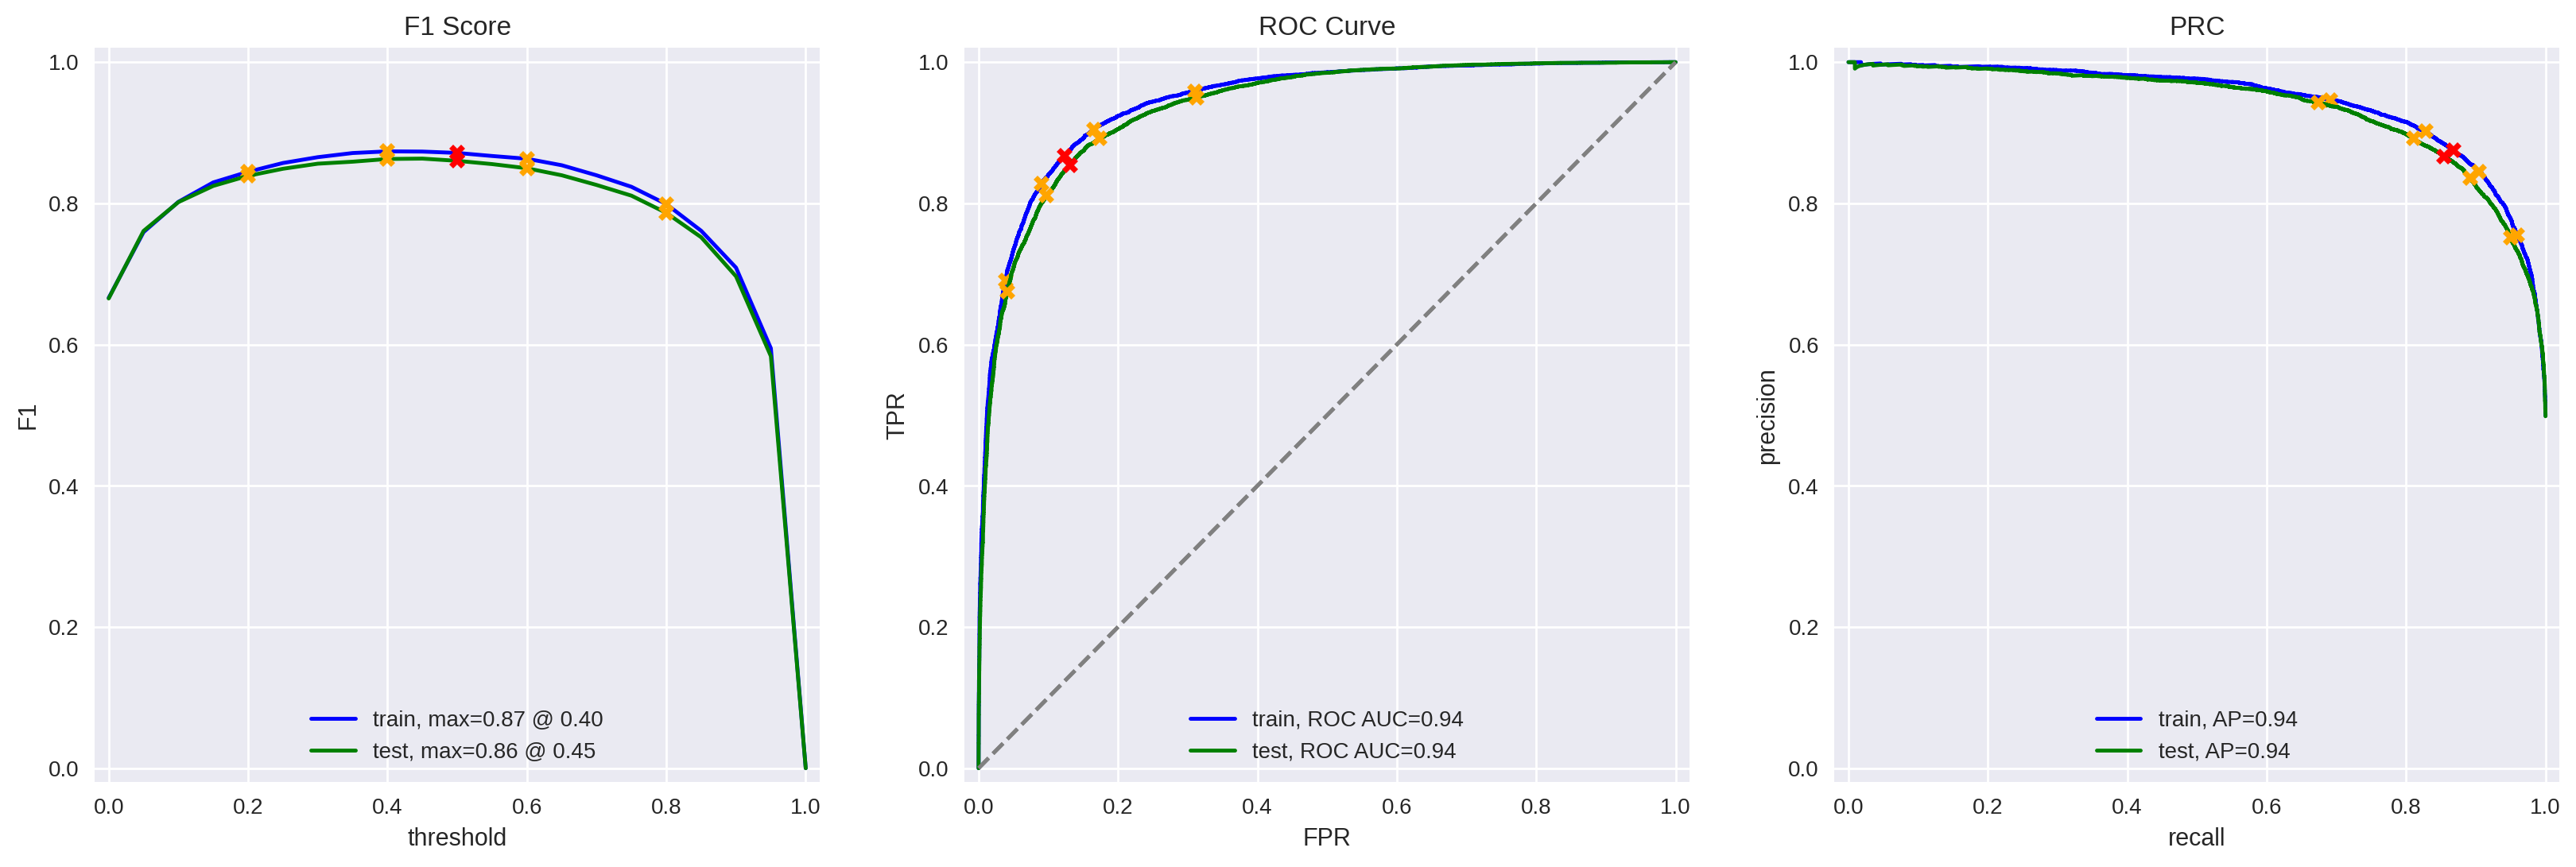

In [65]:
evaluate_model(model_5, 'Mod-5', train_features_5, train_target, test_features_5, test_target)
models.append(['BERT LR'])

In [66]:
# jika sudah mendapatkan embedding, disarankan untuk menyimpannya agar siap 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# dan muat...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [67]:
# np.savez_compressed('features_5.npz', train_features_5=train_features_5, test_features_5=test_features_5)

## Ulasan Saya

In [68]:
# jangan ragu untuk menghapus ulasan ini dan mencoba model Anda sendiri terhadap ulasan Anda, ini hanyalah sekadar contoh 

my_reviews = pd.DataFrame([
    'saya tidak begitu menyukainya, bukan jenis film kesukaan saya.', 
    'Membosankan, bahkan saya tidur di tengah-tengah film.', 
    'Filmnya sangat bagus, saya sangat suka',     
    'Bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya, apakah mereka dibayar untuk bermain film. Sungguh tidak bermutu.', 
    'Saya tidak menyangka filmnya sebagus ini! Para penulis sungguh memperhatikan tiap detailnya', 
    'Film ini memiliki kelebihan dan kekurangan, tetapi saya merasa secara keseluruhan ini adalah film yang layak. Saya mungkin akan menontonnya lagi.', 
    'Beberapa lawakannya sungguh tidak lucu. Tidak ada satu pun lelucon yang berhasil, semua orang bertingkah menyebalkan, bahkan anak-anak pun tidak akan menyukai ini!', 
    'Menayangkan film ini di Netflix adalah langkah yang berani & saya sangat senang bisa menonton episode demi episode dari drama baru yang menarik dan cerdas ini.' 
], columns=['review'])

def clear_text(text):
    clearedText = re.sub(r"[^a-zA-Z' ]"," ",text.lower()).split()
    return " ".join(clearedText)

review_normalized = []
for textraw in my_reviews['review']:
    text_normalized = clear_text(textraw)
    review_normalized.append(text_normalized)
    
my_reviews['review_norm'] = review_normalized
my_reviews_target = [0,0,1,0,1,1,1,0]

df_my_reviews_result = pd.DataFrame()
df_my_reviews_result['Original'] = my_reviews_target
my_reviews

,review,review_norm
0,"saya tidak begitu menyukainya, bukan jenis fil...",saya tidak begitu menyukainya bukan jenis film...
1,"Membosankan, bahkan saya tidur di tengah-tenga...",membosankan bahkan saya tidur di tengah tengah...
2,"Filmnya sangat bagus, saya sangat suka",filmnya sangat bagus saya sangat suka
3,Bahkan para aktornya terlihat sangat tua dan t...,bahkan para aktornya terlihat sangat tua dan t...
4,Saya tidak menyangka filmnya sebagus ini! Para...,saya tidak menyangka filmnya sebagus ini para ...
5,"Film ini memiliki kelebihan dan kekurangan, te...",film ini memiliki kelebihan dan kekurangan tet...
6,Beberapa lawakannya sungguh tidak lucu. Tidak ...,beberapa lawakannya sungguh tidak lucu tidak a...
7,Menayangkan film ini di Netflix adalah langkah...,menayangkan film ini di netflix adalah langkah...


### Model 1

In [69]:
texts = my_reviews['review_norm']

my_reviews_test_features_1 = tfidf_vectorizer_1.transform(texts)
my_reviews_pred_prob = model_1.predict_proba(my_reviews_test_features_1)[:, 1]

df_my_reviews_result['Mod-1'] = model_1.predict(my_reviews_test_features_1)
df_my_reviews_result['Pred-1'] = my_reviews_pred_prob.round(2)

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.65:  saya tidak begitu menyukainya bukan jenis film kesukaan saya
0.51:  membosankan bahkan saya tidur di tengah tengah film
0.48:  filmnya sangat bagus saya sangat suka
0.47:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya apakah mereka dibayar unt
0.46:  saya tidak menyangka filmnya sebagus ini para penulis sungguh memperhatikan tiap detailnya
0.54:  film ini memiliki kelebihan dan kekurangan tetapi saya merasa secara keseluruhan ini adalah film yan
0.39:  beberapa lawakannya sungguh tidak lucu tidak ada satu pun lelucon yang berhasil semua orang bertingk
0.59:  menayangkan film ini di netflix adalah langkah yang berani saya sangat senang bisa menonton episode 


### Model 2

In [70]:
texts = my_reviews['review_norm']

my_reviews_test_features_2 = tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x)))
my_reviews_pred_prob = model_2.predict_proba(my_reviews_test_features_2)[:, 1]

df_my_reviews_result['Mod-2']=model_2.predict(my_reviews_test_features_2)
df_my_reviews_result['Pred-2']=my_reviews_pred_prob.round(2)

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.64:  saya tidak begitu menyukainya bukan jenis film kesukaan saya
0.51:  membosankan bahkan saya tidur di tengah tengah film
0.48:  filmnya sangat bagus saya sangat suka
0.46:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya apakah mereka dibayar unt
0.45:  saya tidak menyangka filmnya sebagus ini para penulis sungguh memperhatikan tiap detailnya
0.53:  film ini memiliki kelebihan dan kekurangan tetapi saya merasa secara keseluruhan ini adalah film yan
0.39:  beberapa lawakannya sungguh tidak lucu tidak ada satu pun lelucon yang berhasil semua orang bertingk
0.62:  menayangkan film ini di netflix adalah langkah yang berani saya sangat senang bisa menonton episode 


### Model 3

In [71]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(my_reviews_test_features_2)[:, 1]
df_my_reviews_result['Mod-3']=model_3.predict(my_reviews_test_features_2)
df_my_reviews_result['Pred-3']=my_reviews_pred_prob.round(2)


for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.62:  saya tidak begitu menyukainya bukan jenis film kesukaan saya
0.62:  membosankan bahkan saya tidur di tengah tengah film
0.61:  filmnya sangat bagus saya sangat suka
0.61:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya apakah mereka dibayar unt
0.61:  saya tidak menyangka filmnya sebagus ini para penulis sungguh memperhatikan tiap detailnya
0.62:  film ini memiliki kelebihan dan kekurangan tetapi saya merasa secara keseluruhan ini adalah film yan
0.61:  beberapa lawakannya sungguh tidak lucu tidak ada satu pun lelucon yang berhasil semua orang bertingk
0.67:  menayangkan film ini di netflix adalah langkah yang berani saya sangat senang bisa menonton episode 


### Model 4

In [72]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(my_reviews_test_features_2)[:, 1]
df_my_reviews_result['Mod-4']=model_4.predict(my_reviews_test_features_2)
df_my_reviews_result['Pred-4']=my_reviews_pred_prob.round(2)

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.60:  saya tidak begitu menyukainya bukan jenis film kesukaan saya
0.60:  membosankan bahkan saya tidur di tengah tengah film
0.60:  filmnya sangat bagus saya sangat suka
0.60:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya apakah mereka dibayar unt
0.60:  saya tidak menyangka filmnya sebagus ini para penulis sungguh memperhatikan tiap detailnya
0.60:  film ini memiliki kelebihan dan kekurangan tetapi saya merasa secara keseluruhan ini adalah film yan
0.60:  beberapa lawakannya sungguh tidak lucu tidak ada satu pun lelucon yang berhasil semua orang bertingk
0.64:  menayangkan film ini di netflix adalah langkah yang berani saya sangat senang bisa menonton episode 


### Model 5

In [73]:
texts = my_reviews['review_norm']

my_reviews_features_5 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_5.predict_proba(my_reviews_features_5)[:, 1]
df_my_reviews_result['Mod-5']=model_5.predict(my_reviews_features_5)
df_my_reviews_result['Pred-5']=my_reviews_pred_prob.round(2)
df_my_reviews_result['Review']=texts

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.52:  saya tidak begitu menyukainya bukan jenis film kesukaan saya
0.14:  membosankan bahkan saya tidur di tengah tengah film
0.67:  filmnya sangat bagus saya sangat suka
0.19:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya apakah mereka dibayar unt
0.42:  saya tidak menyangka filmnya sebagus ini para penulis sungguh memperhatikan tiap detailnya
0.70:  film ini memiliki kelebihan dan kekurangan tetapi saya merasa secara keseluruhan ini adalah film yan
0.85:  beberapa lawakannya sungguh tidak lucu tidak ada satu pun lelucon yang berhasil semua orang bertingk
0.63:  menayangkan film ini di netflix adalah langkah yang berani saya sangat senang bisa menonton episode 


In [74]:
print(print_separator)
print('Model Names used')
df_models = pd.DataFrame(models,columns=['Model (M)'])
display(df_models)
print(print_separator)
print('Evaluation Results of Various Models on the Reviews dataset')
display(df_results)
print(print_separator)
print('Matrix of Predictions on MyReviews')
display(df_my_reviews_result)
print(print_separator)

****************************************************************************************************
Model Names used


,Model (M)
0,DummyClassifier
1,NLTK TF-IDF LR
2,spaCy TF-IDF LR
3,spaCy TF-IDF LGBM
4,spaCy TF-IDF XGB
5,BERT LR


****************************************************************************************************
Evaluation Results of Various Models on the Reviews dataset


,Mod-0 train,Mod-0 test,Mod-1 train,Mod-1 test,Mod-2 train,Mod-2 test,Mod-3 train,Mod-3 test,Mod-4 train,Mod-4 test,Mod-5 train,Mod-5 test
Accuracy,0.50,0.50,0.94,0.88,0.93,0.88,0.91,0.86,0.95,0.85,0.87,0.86
F1,0.67,0.67,0.94,0.88,0.93,0.88,0.91,0.86,0.95,0.85,0.87,0.86
APS,0.50,0.50,0.98,0.95,0.98,0.95,0.97,0.93,0.99,0.93,0.94,0.94
ROC AUC,0.50,0.50,0.98,0.95,0.98,0.95,0.97,0.94,0.99,0.93,0.94,0.94


****************************************************************************************************
Matrix of Predictions on MyReviews


,Original,Mod-1,Pred-1,Mod-2,Pred-2,Mod-3,Pred-3,Mod-4,Pred-4,Mod-5,Pred-5,Review
0,0,1,0.65,1,0.64,1,0.62,1,0.60,1,0.52,saya tidak begitu menyukainya bukan jenis film...
1,0,1,0.51,1,0.51,1,0.62,1,0.60,0,0.14,membosankan bahkan saya tidur di tengah tengah...
2,1,0,0.48,0,0.48,1,0.61,1,0.60,1,0.67,filmnya sangat bagus saya sangat suka
3,0,0,0.47,0,0.46,1,0.61,1,0.60,0,0.19,bahkan para aktornya terlihat sangat tua dan t...
4,1,0,0.46,0,0.45,1,0.61,1,0.60,0,0.42,saya tidak menyangka filmnya sebagus ini para ...
5,1,1,0.54,1,0.53,1,0.62,1,0.60,1,0.70,film ini memiliki kelebihan dan kekurangan tet...
6,1,0,0.39,0,0.39,1,0.61,1,0.60,1,0.85,beberapa lawakannya sungguh tidak lucu tidak a...
7,0,1,0.59,1,0.62,1,0.67,1,0.64,1,0.63,menayangkan film ini di netflix adalah langkah...


****************************************************************************************************


## Kesimpulan

Enam Model dievaluasi dengan pemrosesan teks yang berbeda dari fitur train dan test.

Skor model Teratas:

- NTLK + TF-IDF + LogisticRegression, skor F1 0,88
- spaCy + TF-IDF + LogisticRegression, skor F1 0,88
- spaCy + TF-IDF + LGBMClassifier, skor F1 0,86
- BERT + LogisticRegression, skor F1 0,86

Skor model Terendah:

- spaCy + TF-IDF + XGBoost memiliki skor rendah 0,85
- DummyClassifier, skor terendah 0,67

My Review:

- Model NTLK + TF-IDF + LogisticRegression menghasilkan nilai F1 yang jauh lebih baik dibandingkan model dummy classifier dan melewati nilai threshold.
- Meskipun hasil skor F1 NLTK, TF-IDF dengan XGBoost tidak lebih baik daripada hasil vektorisasi dengan LogisticRegression, model ini kurang rentan terhadap overfitting.
- Model spaCy + TF-IDF + LogisticRegression menghasilkan nilai F1 yang sama dengan NLTK, TF-IDF namun dengan hasil yang sedikit lebih baik.
- Model spaCy + TF-IDF + LGBMClassifier menghasilkan nilai F1 yang tidak lebih baik dari model spaCy + TF-IDF + LogisticRegression.
- Model BERT + LogisticRegression memberikan hasil yang tidak jauh berbeda dengan model sebelumnya, namun model ini memiliki kinerja yang lebih baik karena bebas dari overfitting. 
Model ini memang menghasilkan performa terbaik dan bebas dari overfitting, namun membutuhkan waktu yang sangat lama untuk bertransformasi. Model ini dapat dipertimbangkan jika tujuan utamanya adalah mendapatkan hasil F1 terbaik.
Tetapi jika fokus utamanya adalah waktu transformasi, disarankan menggunakan NLTK, TF-IDF dan XGBoost, yang memiliki hasil yang mirip dengan model BERT.

In [75]:
print("Thank you for evaluating my project, Looking forward to your feedback")

Thank you for evaluating my project, Looking forward to your feedback


# Daftar Periksa

- [x]  *Notebook* dibuka 
- [ ]  Data teks telah dimuat dan dilakukan pra-pemrosesan untuk vektorisasi 
- [ ]  Data teks telah diubah menjadi vektor 
- [ ]  Model telah terlatih dan diuji 
- [ ]  Ambang batas metrik tercapai 
- [ ]  Semua kode sel tersusun sesuai urutan eksekusinya 
- [ ]  Semua kode sel bisa dieksekusi tanpa *error* 
- [ ]  Terdapat kesimpulan 